# Hard and soft constraints

### Hard constraints
These are constraints that must be pursued during the search and without meeting these constraints, the solution is not true. These constraints are:
- All classes must be scheduled
- No classes or lecturers are allocated twice at same time

### Soft constraints
These constraints that are not mandatory for a solution must be pursued, but the quality of the courses schedule is decided by following these constraints
- classes scheduled within preferred hours
- Avoid long runs of consecutive lectures

# Initialization

In [50]:
import numpy as np
from numpy import random
from itertools import product
from prettytable import PrettyTable
import csv
import pandas as pd
import textwrap

In [51]:
# Initialization to convert input from user into a single data
def initialize(students, courses, day_times, prof_input):
    initialized_data = {}
    initialized_data["stgs"] = students
    initialized_data["courses"] = courses
    initialized_data["days"] = day_times["days"]
    initialized_data["periods"] = day_times["periods"]
    availability_product = list(product(initialized_data["days"], initialized_data["periods"]))
    availability_list = [list(elem) for elem in availability_product]
    prof_data = {}
    for prof in prof_input.keys():
        current_available = availability_list.copy()
        unavailables = prof_input[prof]["unavailable"]
        for elem in unavailables:
            current_available.remove(elem)
        prof_data[prof]= {"availability_list" : current_available}
    initialized_data["profs"] = prof_data
    return initialized_data

In [52]:
# Generating a random initial population
def generate_population(n, input_data):
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    chromosome_length = 0
    for stg in stgs:
        chromosome_length += input_data["stgs"][stg]["hour"]

    population = []
    for _ in range(n):
        cur_individual = []
        for _ in range(chromosome_length):
            stg = random.choice(stgs)
            course = random.choice(courses)
            prof = random.choice(profs)
            day = random.choice(days)
            period = random.choice(periods)
            cur_chromosome = {"stg": stg, "course": course, "prof": prof,
            "day": day, "period": period}
            cur_individual.append(cur_chromosome)
        population.append(cur_individual)
    return population

# Evolutionary functions

In [53]:
# Fitness function
# TODO: add soft constraints
def fitness_function(matrix, data):
    stgs = [ key for key in data["stgs"].keys()]
    courses = [ key for key in data["courses"].keys()]
    profs = [key for key in data["profs"].keys()]
    stg_checker = {}
    course_checker = {}
    prof_checker = {}
    for stg in stgs:
        stg_checker[stg] = []
        course_list = data["stgs"][stg]["course_list"]
        course_checker[stg] = {}
        for course in course_list:
            course_checker[stg][course] = 0
        course_checker
    for prof in profs:
        prof_checker[prof] = []

    hard_penalty_counter = 0
    for chromosome in matrix:
        stg = chromosome["stg"]
        course = chromosome["course"]
        prof = chromosome["prof"]
        day = chromosome["day"]
        period = chromosome["period"]
        course_list = data["stgs"][stg]["course_list"]
        if course in course_list:
            course_checker[stg][course] += 1
        if course not in data["stgs"][stg]["course_list"]:
            hard_penalty_counter += 1
        if prof not in data["courses"][course]["prof_list"]:
            hard_penalty_counter += 1
        timeslot = [day, period]
        if timeslot not in stg_checker[stg]:
            stg_checker[stg].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in prof_checker[prof]:
            prof_checker[prof].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in data["profs"][prof]["availability_list"]:
            hard_penalty_counter += 1
    for course_key in course_checker.keys():
        pass
    for stg in stgs:
        if len(stg_checker[stg]) != data["stgs"][stg]["hour"]:
            abs_diff = np.abs(len(stg_checker[stg]) - data["stgs"][stg]["hour"]) 
            hard_penalty_counter += abs_diff
        for course_key in course_checker[stg].keys():
            if course_checker[stg][course_key] != data["courses"][course_key]["hour"]:
                abs_diff = np.abs(course_checker[stg][course_key] - data["courses"][course_key]["hour"]) 
                hard_penalty_counter += abs_diff
    
    # Check for soft constraints
    soft_penalty_counter = 0

    hard_penalty_resolved = True if hard_penalty_counter == 0 else False

    result = 1/(1+(soft_penalty_counter + hard_penalty_counter))
    return result, hard_penalty_resolved

In [54]:
# individual = [
    
#  {'stg': 10000, 'course': 11752, 'prof': 10003, 'day': 0, 'period': 7},
#  {'stg': 10000, 'course': 11753, 'prof': 10003, 'day': 0, 'period': 8},
#  {'stg': 10000, 'course': 11752, 'prof': 10003, 'day': 0, 'period': 9},
#  {'stg': 10000, 'course': 11753, 'prof': 10003, 'day': 0, 'period': 10},
#  {'stg': 10000, 'course': 11752, 'prof': 10003, 'day': 0, 'period': 11},
#  {'stg': 10000, 'course': 11753, 'prof': 10003, 'day': 1, 'period': 7},
#  {'stg': 10004, 'course': 11764, 'prof': 10010, 'day': 3, 'period': 9},
#  {'stg': 10004, 'course': 11765, 'prof': 10010, 'day': 2, 'period': 8},
#  {'stg': 10004, 'course': 11764, 'prof': 10010, 'day': 2, 'period': 9},
#  {'stg': 10004, 'course': 11765, 'prof': 10010, 'day': 2, 'period': 10},
#  {'stg': 10004, 'course': 11764, 'prof': 10010, 'day': 2, 'period': 11},
#  {'stg': 10004, 'course': 11765, 'prof': 10010, 'day': 2, 'period': 7}]
# print(len(individual))
# fitness_value = fitness_function(individual, initialized_data)
# print(fitness_value)

In [55]:
# One point crossover from index 1 to last index
def one_point_crossover(parent_1, parent_2, crossover_rate=0.8):
    crossover_point = random.randint(1, len(parent_1))
    child_1 = parent_1.copy()
    if (random.random() < crossover_rate):
        child_1[crossover_point:] = parent_2[crossover_point:]
    return child_1

In [56]:
# Mutation by Random resetting
DEFAULT_MUTATION_RATE = 0.05
def mutation(individual, input_data, mutation_rate):
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    for mutate_index in range(len(individual)):
        mutation_prob = random.random()
        if (mutation_prob < mutation_rate):
            mutate_attr = random.randint(len(individual))
            if mutate_attr == 0:
                individual[mutate_index]["stg"] = random.choice(stgs)
            if mutate_attr == 1:
                individual[mutate_index]["course"] = random.choice(courses)
            if mutate_attr == 2:
                individual[mutate_index]["prof"] = random.choice(profs)
            if mutate_attr == 3:
                individual[mutate_index]["day"] = random.choice(days)
            if mutate_attr == 4:
                individual[mutate_index]["period"] = random.choice(periods)
    return individual

In [57]:
# Selection by ranking
# Choose top 0.1 and then reproduce until same length as population
def get_new_population_selection_by_ranking(population, fitness_values, data, mutation_rate=DEFAULT_MUTATION_RATE):
    zipped_population = [(x,y) for x,y in zip(population, fitness_values)]
    sorted_population = sorted(zipped_population,key=lambda x: x[1], reverse=True)
    population_length = len(population)
    elites = sorted_population[:population_length//10]
    elites = [x[0] for x in elites]
    new_gen = []
    for _ in range(population_length):
        parent_x_idx = random.randint(len(elites))
        parent_y_idx = random.randint(len(elites))
        while parent_x_idx == parent_y_idx:
            parent_y_idx = random.randint(len(elites))
        parent_x, parent_y = elites[parent_x_idx], elites[parent_y_idx]
        child_1= one_point_crossover(parent_x, parent_y)
        mutated_1= mutation(child_1, data, mutation_rate)
        new_gen.append(mutated_1)
    return new_gen

In [58]:
# Main genetic algorithm function
def genetic_algorithm(input_fitness_values, input_population, input_data, DEBUG=False, debug_num=100):
    counter = 0
    current_fitness_values = input_fitness_values.copy()
    current_population = input_population.copy()
    solution = {}
    avg_fitness_list = []
    max_fitness_list = []
    stuck_counter = 0
    mutation_rate = DEFAULT_MUTATION_RATE
    stuck_limit = 5000
    MAX_MUTATION_RATE = 5*DEFAULT_MUTATION_RATE
    GENERATION_LIMIT = 100000
    while True:
        swap_happened = False
        new_population = get_new_population_selection_by_ranking(current_population, current_fitness_values, input_data, mutation_rate)
        new_fitness_values= []
        is_solution_checker = []
        for idx in range(len(new_population)):
            fitness_value, is_solution = fitness_function(new_population[idx], input_data)
            new_fitness_values.append(fitness_value)
            is_solution_checker.append(is_solution)
        for i in range(len(new_fitness_values)):
            if new_fitness_values[i] > current_fitness_values[i]:
                current_population[i] = new_population[i]
                current_fitness_values[i] = new_fitness_values[i]
                swap_happened = True
                mutation_rate = DEFAULT_MUTATION_RATE
                stuck_counter = 0
        counter += 1
        max_fitness = np.max(current_fitness_values)
        avg_fitness = np.mean(current_fitness_values)
        max_fitness_list.append(max_fitness)
        avg_fitness_list.append(avg_fitness)
        if True in is_solution_checker:
            index = is_solution_checker.index(True)
            print("SOLUTION FOUND", "\nGeneration count:", counter, "\nSolution:", new_population[index])
            solution = new_population[index]
            break
        if swap_happened == False:
            stuck_counter += 1
        if stuck_counter == stuck_limit:
            if mutation_rate < MAX_MUTATION_RATE:
                stuck_counter = 0
                mutation_rate += 0.01
                print(mutation_rate)
        if counter == GENERATION_LIMIT:
            print("Generation limit has been reached")
            break
        if DEBUG:
            if counter % debug_num == 0:
                print(counter, max_fitness, avg_fitness)
    return solution, avg_fitness_list, max_fitness_list

# Input (Program begins here)

#### Functions to assign course and professor names

In [59]:
def assign_student_group(input_data, musi=False):
    assigned_stgs = {}
    stgs = [ key for key in input_data["stgs"].keys()]
    if (not musi):
        words = list(csv.reader(open("groups.csv")))
        rand_nums = random.choice(range(len(words)), len(stgs))
        for stg, rand_num in zip(stgs, rand_nums):
            rand_group = words[rand_num][0]
            assigned_stgs[stg] = rand_group
    if (musi):
        words = list(csv.reader(open("groups.csv")))
        for stg in stgs:
            words = list(csv.reader(open("musi_groups.csv")))
            stg_num = stg % 10000
            musi_stg = words[stg_num][0]
            assigned_stgs[stg] = musi_stg
    return assigned_stgs

In [60]:
def assign_courses(input_data, musi=False):
    assigned_courses = {}
    courses = [ key for key in input_data["courses"].keys()]
    if (not musi):
        words = list(csv.reader(open("courses.csv")))
        rand_nums = random.choice(range(len(words)), len(courses))
        for course, rand_num in zip(courses, rand_nums):
            rand_num = random.randint(len(words))
            rand_course = words[rand_num][0]
            assigned_courses[course] = rand_course
    if (musi):
        for course in courses:
            df_course = pd.read_csv("musi_courses.csv", header=None)
            musi_course = df_course.loc[df_course[0] == course][1].item()
            assigned_courses[course] = musi_course
    return assigned_courses

In [61]:
def assign_profs(input_data, musi=False):
    assigned_profs = {}
    profs = [ key for key in input_data["profs"].keys()]
    if (not musi):
        words = list(csv.reader(open("profs.csv")))
        rand_nums = random.choice(range(len(words)), len(profs))
        for prof, rand_num in zip(profs, rand_nums):
            rand_prof = "Prof. " + words[rand_num][0]
            assigned_profs[prof] = rand_prof
    if (musi):
        for prof in profs:
            words = list(csv.reader(open("musi_profs.csv")))
            prof_num = prof % 10000
            musi_prof = words[prof_num][0]
            assigned_profs[prof] = musi_prof
    return assigned_profs

In [62]:
def generate_timeslots(input_days, input_periods):
    products = list(product(input_days, input_periods))
    timeslots = [list(elem) for elem in products]
    return timeslots

#### Different kinds of input

In [63]:
def musi_input_easy():
    student_input = {
        10000: {"hour": 6, "course_list": [11752,11753]},
        10004: {"hour": 6, "course_list": [11764,11765]},
        }
    course_input = {
        11752: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11753: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11764: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11765: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [6,7,8,9,10,11]}
    prof_input = {
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []},
    }
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [64]:
def musi_input_medium():
    student_input = {
        10000: {"hour": 10, "course_list": [11750,11751,11752,11753]},
        10004: {"hour": 10, "course_list": [11750,11751,11764,11765]}
        }
    course_input = {
        11750: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}, 
        11751: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11752: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11753: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11764: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11765: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [7,8,9,10,11]}
    
    prof_input = {
        10000: {"unavailable": []},
        10001: {"unavailable": []},
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []}
        } # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [65]:
def musi_input_hard():
    student_input = {
        10000: {"hour": 10, "course_list": [11750,11751,11752,11753]},
        10004: {"hour": 10, "course_list": [11750,11751,11764,11765]}
        }
    course_input = {
        11750: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}, 
        11751: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11752: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11753: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11764: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11765: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [7,8,9,10,11]}
    
    prof_input = {
        10000: {"unavailable": []},
        10001: {"unavailable": []},
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []}
        } # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [66]:
def musi_input_real_case():
    # Student groups:
    # 10000 - Artificial Intelligence
    # 10001 - Computer Vision
    # 10002 - Data Science
    # 10003 - Internet of Things
    # 10004 - Mobile Robotics

    # Courses
    # 11750 - scientific research methodology
    # 11751 - Research Management and Innovation
    # 11752 - Automatic Learning
    # 11753 - Computational Intelligence
    # 11760 - Computer Vision and 3-D Reconstruction
    # 11761 - Image and Video Analysis
    # 11756 - Storage and Data Recovery
    # 11757 - Complex Networks
    # 11768 - Distributed Embedded Systems and Domotics
    # 11769 - System Connectivity and Integration in IoT
    # 11764 - Mobile Robot Sensorization and Control
    # 11765 - Navigation and Environment Modelling in Mobile Robotics

    # Profs
    # 10000 - Prof. Margarita
    # 10001 - Prof. Belén
    # 10002 - Prof. Alberto
    # 10003 - Prof. Sebastián
    # 10004 - Prof. Gabriel
    # 10005 - Prof. Pedro
    # 10006 - Prof. Jaime
    # 10007 - Prof. Joan
    # 10008 - Prof. Julián
    # 10009 - Prof. Manuel
    # 10010 - Prof. José
    # 10011 - Prof. Eric

    student_input = {
        10000: {"hour": 10, "course_list": [11750,11751,11752,11753]},
        10001: {"hour": 10, "course_list": [11750,11751,11760,11761]},
        10002: {"hour": 10, "course_list": [11750,11751,11756,11757]},
        10003: {"hour": 10, "course_list": [11750,11751,11768,11769]},
        10004: {"hour": 10, "course_list": [11750,11751,11764,11765]}}
    course_input = {
        11750: {"hour": 2, "prof_list": [10000]}, 
        11751: {"hour": 2, "prof_list": [10001]},
        11752: {"hour": 3, "prof_list": [10002]},
        11753: {"hour": 3, "prof_list": [10003]},
        11760: {"hour": 3, "prof_list": [10004]},
        11761: {"hour": 3, "prof_list": [10005]},
        11756: {"hour": 3, "prof_list": [10006]},
        11757: {"hour": 3, "prof_list": [10007]},
        11768: {"hour": 3, "prof_list": [10008]},
        11769: {"hour": 3, "prof_list": [10009]},
        11764: {"hour": 3, "prof_list": [10010]},
        11765: {"hour": 3, "prof_list": [10011]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [7,8,9,10,11]}
    unavail_10000_1 = generate_timeslots([0,1,3,4], day_time_availability["periods"])
    unavail_10000_2 = generate_timeslots([2], day_time_availability["periods"][2:])
    unavail_10001_1 = generate_timeslots([0,1,2,4], day_time_availability["periods"])
    unavail_10001_2 = generate_timeslots([3], day_time_availability["periods"][2:])
    unavail_10002_1 = generate_timeslots([1,2,4], day_time_availability["periods"])
    unavail_10002_2 = generate_timeslots([0], [7,8,11])
    unavail_10002_3 = generate_timeslots([3], [7,8,10,11])
    unavail_10003_1 = generate_timeslots([1,2,4], day_time_availability["periods"])
    unavail_10003_2 = generate_timeslots([0], [9,10,11])
    unavail_10003_3 = generate_timeslots([3], [7,8,9,11])
    unavail_10004_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10004_2 = generate_timeslots([1], [7,8,11])
    unavail_10004_3 = generate_timeslots([4], [7,8,9])
    unavail_10005_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10005_2 = generate_timeslots([1], [9,10,11])
    unavail_10005_3 = generate_timeslots([4], [7,8,10,11])
    unavail_10006_1 = generate_timeslots([0,1,3,4], day_time_availability["periods"])
    unavail_10006_2 = generate_timeslots([2], [7,8])
    unavail_10007_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10007_2 = generate_timeslots([1], [7,8,9,10])
    unavail_10007_3 = generate_timeslots([4], [9,10,11])
    unavail_10008_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10008_2 = generate_timeslots([1], [7,8,11])
    unavail_10008_3 = generate_timeslots([4], [7,8,10,11])
    unavail_10009_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10009_2 = generate_timeslots([1], [9,10,11])
    unavail_10009_3 = generate_timeslots([4], [7,8,9,11])
    unavail_10010_1 = generate_timeslots([0,1,3], day_time_availability["periods"])
    unavail_10010_2 = generate_timeslots([2], [7,8,10,11])
    unavail_10010_3 = generate_timeslots([4], [9,10,11])
    unavail_10011_1 = generate_timeslots([0,3,4], day_time_availability["periods"])
    unavail_10011_2 = generate_timeslots([1], [7,8,9,10])
    unavail_10011_3 = generate_timeslots([2], [7,8,9])
    

    prof_input = {
        10000: {"unavailable": unavail_10000_1 + unavail_10000_2},
        10001: {"unavailable": unavail_10001_1 + unavail_10001_2},
        10002: {"unavailable": unavail_10002_1 + unavail_10002_2 + unavail_10002_3},
        10003: {"unavailable": unavail_10003_1 + unavail_10003_2 + unavail_10003_3},
        10004: {"unavailable": unavail_10004_1 + unavail_10004_2 + unavail_10004_3},
        10005: {"unavailable": unavail_10005_1 + unavail_10005_2 + unavail_10005_3},
        10006: {"unavailable": unavail_10006_1 + unavail_10006_2},
        10007: {"unavailable": unavail_10007_1 + unavail_10007_2 + unavail_10007_3},
        10008: {"unavailable": unavail_10008_1 + unavail_10008_2 + unavail_10008_3},
        10009: {"unavailable": unavail_10009_1 + unavail_10009_2 + unavail_10009_3},
        10010: {"unavailable": unavail_10010_1 + unavail_10010_2 + unavail_10010_3},
        10011: {"unavailable": unavail_10011_1 + unavail_10011_2 + unavail_10011_3}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [67]:
def easy_input():
    student_input = {0: {"hour": 4, "course_list": [0]}, 1: {"hour": 3, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [68]:
def medium_input():
    student_input = {0: {"hour": 16, "course_list": [0,1,2,3,4,5]}, 1: {"hour": 16, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [69]:
def hard_input():
    student_input = {0: {"hour": 4, "course_list": [0]}, 1: {"hour": 3, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

#### Choosing which degree of input will be used for the algorithm

In [70]:
initialized_data = musi_input_easy()
musi = True
assigned_groups = assign_student_group(initialized_data, musi)
assigned_courses = assign_courses(initialized_data, musi)
assigned_profs = assign_profs(initialized_data, musi)
population_num = 100

print(initialized_data)
stgs = [ key for key in initialized_data["stgs"].keys()]
courses = [ key for key in initialized_data["courses"].keys()]
profs = [key for key in initialized_data["profs"].keys()]
days = initialized_data["days"]
periods = initialized_data["periods"]

{'stgs': {10000: {'hour': 6, 'course_list': [11752, 11753]}, 10004: {'hour': 6, 'course_list': [11764, 11765]}}, 'courses': {11752: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11753: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11764: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11765: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}}, 'days': [0, 1, 2, 3, 4], 'periods': [6, 7, 8, 9, 10, 11], 'profs': {10002: {'availability_list': [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11]]}, 10003: {'availability_list': [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [

#### Generating initial population

In [71]:
initial_population = generate_population(population_num, initialized_data)
initial_fitness_values = []
for idx in range(len(initial_population)):
    fitness_value, _ = fitness_function(initial_population[idx], initialized_data)
    initial_fitness_values.append(fitness_value)
print(np.max(initial_fitness_values), np.mean(initial_fitness_values))

0.125 0.0622277285568754


#### Calling the genetic algorithm function

In [72]:
DEBUG = True
debug_num = 1000
solution, avg_fitness_list, max_fitness_list = genetic_algorithm(initial_fitness_values, initial_population, initialized_data, DEBUG=DEBUG, debug_num=debug_num)

1000 0.3333333333333333 0.17329761904761903
2000 0.3333333333333333 0.2048571428571428
3000 0.3333333333333333 0.22399999999999998
4000 0.3333333333333333 0.22399999999999998
5000 0.3333333333333333 0.22399999999999998
6000 0.3333333333333333 0.23033333333333336
7000 0.3333333333333333 0.23033333333333336
8000 0.3333333333333333 0.23083333333333333
9000 0.3333333333333333 0.23483333333333334
10000 0.3333333333333333 0.23483333333333334
11000 0.3333333333333333 0.23483333333333334
12000 0.3333333333333333 0.2375
13000 0.3333333333333333 0.2375
14000 0.3333333333333333 0.2375
15000 0.3333333333333333 0.2375
16000 0.3333333333333333 0.2375
17000 0.3333333333333333 0.23883333333333334
18000 0.3333333333333333 0.23983333333333334
19000 0.3333333333333333 0.24599999999999997
20000 0.3333333333333333 0.25933333333333336
21000 0.3333333333333333 0.25933333333333336
22000 0.3333333333333333 0.25933333333333336
23000 0.3333333333333333 0.25933333333333336
24000 0.3333333333333333 0.2593333333333

# Timetable showcase

In [73]:
def get_mapped_value(value, value_type, input_dict={}):
    result = ""
    if value_type == "days":
        if value == 0:
            result = "Monday"
        if value == 1:
            result = "Tuesday"
        if value == 2:
            result = "Wednesday"
        if value == 3:
            result = "Thursday"
        if value == 4:
            result = "Friday"
        if value == 5:
            result = "Saturday"
        if value == 6:
            result = "Sunday"
        if value < 0 or value >= 7:
            result = "Day " + str(value)
    
    if value_type == "periods":
        time_from = value + 8
        time_to = time_from + 1
        result = str(time_from).zfill(2) + ":30" + " - " + str(time_to).zfill(2) + ":30"

    if value_type == "groups":
        result = input_dict[value]

    if value_type == "courses":
        result = input_dict[value]
    
    if value_type == "profs":
        result = input_dict[value]
    return result

for stg in stgs:
    table = PrettyTable()
    stg_mapped = get_mapped_value(stg, "courses", assigned_groups)
    table.title = 'Schedule for student group ' + stg_mapped
    field_names = ['']
    for day in days:
        day = get_mapped_value(day, "days")
        field_names.append(day)
    table.field_names = field_names
    rows = []
    for period_num in periods:
        current_period = [get_mapped_value(period_num, "periods")]
        for _ in days:
            current_period.append("")
        rows.append(current_period)
    for chromosome in solution:
        if chromosome['stg'] == stg:
            chr_day = chromosome['day']
            chr_period = chromosome['period']
            chr_course = chromosome['course']
            chr_course = get_mapped_value(chr_course, "courses", assigned_courses)
            chr_prof = chromosome['prof']
            chr_prof = get_mapped_value(chr_prof, "profs", assigned_profs)
            day_idx = days.index(chr_day)
            period_idx = periods.index(chr_period)
            rows[period_idx][day_idx + 1] = textwrap.fill(chr_course, 20) + "\n- " + chr_prof
        
    for row in rows:
        table.add_row(row)

    print(table)

+--------------------------------------------------------------------------------------------------+
|                        Schedule for student group Artificial Intelligence                        |
+---------------+--------+--------------------+--------------------+----------+--------------------+
|               | Monday |      Tuesday       |     Wednesday      | Thursday |       Friday       |
+---------------+--------+--------------------+--------------------+----------+--------------------+
| 14:30 - 15:30 |        |                    |   Computational    |          |                    |
|               |        |                    |    Intelligence    |          |                    |
|               |        |                    |    - Prof. José    |          |                    |
| 15:30 - 16:30 |        |                    |                    |          | Automatic Learning |
|               |        |                    |                    |          | - Prof. Seb

# Performance evaluation

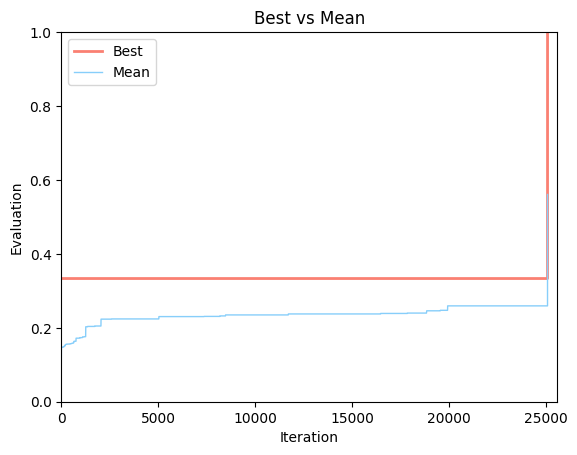

In [74]:
import matplotlib.pyplot as plt

x_limit = len(avg_fitness_list) + len(avg_fitness_list)//50
y_limit_high = np.max(max_fitness_list)

plt.xlim(0, x_limit)
plt.ylim(0, y_limit_high)
plt.plot(max_fitness_list, linewidth=2, color="salmon")
plt.plot(avg_fitness_list, linewidth=1, color="lightskyblue")
plt.ylabel("Evaluation")
plt.xlabel("Iteration")
plt.legend(["Best", "Mean"], loc="upper left")
plt.title("Best vs Mean")
plt.show()